# Tomographic Reconstruction: Total Variation regularization

Description: implementing  Total Variation (TV) regularized tomographic reconstruction using an ISTA-like optimization algorithm. It also mentions a comparison with a deep-learning-based unrolling method, for which external reconstructions are provided.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
!unzip /content/drive/MyDrive/checkpoints.zip
!mv checkpoints /content/drive/MyDrive

Archive:  /content/drive/MyDrive/checkpoints.zip
  inflating: checkpoints/LPD_-30_30_angles30.pth  


In [5]:
!unzip /content/drive/MyDrive/MayoDataset.zip
!mv Mayo_s\ Dataset MajoDataset

import os
import shutil
from PIL import Image

# path alla cartella MajoDataset (modifica se serve)
root_dir = '/content/MajoDataset'

for split in ['train', 'test']:
    split_dir = os.path.join(root_dir, split)
    # scorri tutte le voci dentro train/ test
    for folder_name in os.listdir(split_dir):
        folder_path = os.path.join(split_dir, folder_name)
        if os.path.isdir(folder_path):
            # per ogni file nella sottocartella
            for fname in os.listdir(folder_path):
                src = os.path.join(folder_path, fname)
                # nuovo nome = nome della cartella + '_' + nome file
                new_fname = f"{folder_name}_{fname}"
                dst = os.path.join(split_dir, new_fname)
                # gestisci eventuali collisioni
                if os.path.exists(dst):
                    base, ext = os.path.splitext(new_fname)
                    i = 1
                    while True:
                        candidate = f"{base}_{i}{ext}"
                        candidate_path = os.path.join(split_dir, candidate)
                        if not os.path.exists(candidate_path):
                            dst = candidate_path
                            break
                        i += 1
                # sposta il file
                shutil.move(src, dst)

                # --- RESIZE DELL'IMMAGINE ---
                try:
                    with Image.open(dst) as img:
                        img = img.convert("RGB")  # garantiamo che sia RGB
                        img = img.resize((256, 256), Image.LANCZOS)
                        img.save(dst)
                except Exception as e:
                    print(f"Errore nel processare {dst}: {e}")

            # elimina la sottocartella vuota
            os.rmdir(folder_path)

print("Operazione completata! Tutti i file sono stati spostati, rinominati e resizzati a 256x256.")


Archive:  /content/drive/MyDrive/MayoDataset.zip
  inflating: Mayo_s Dataset/test/C081/307.png  
  inflating: Mayo_s Dataset/test/C081/303.png  
  inflating: Mayo_s Dataset/test/C081/321.png  
  inflating: Mayo_s Dataset/test/C081/315.png  
  inflating: Mayo_s Dataset/test/C081/300.png  
  inflating: Mayo_s Dataset/test/C081/290.png  
  inflating: Mayo_s Dataset/test/C081/314.png  
  inflating: Mayo_s Dataset/test/C081/288.png  
  inflating: Mayo_s Dataset/test/C081/301.png  
  inflating: Mayo_s Dataset/test/C081/323.png  
  inflating: Mayo_s Dataset/test/C081/322.png  
  inflating: Mayo_s Dataset/test/C081/312.png  
  inflating: Mayo_s Dataset/test/C081/298.png  
  inflating: Mayo_s Dataset/test/C081/316.png  
  inflating: Mayo_s Dataset/test/C081/310.png  
  inflating: Mayo_s Dataset/test/C081/309.png  
  inflating: Mayo_s Dataset/test/C081/313.png  
  inflating: Mayo_s Dataset/test/C081/308.png  
  inflating: Mayo_s Dataset/test/C081/318.png  
  inflating: Mayo_s Dataset/test/C081/3

In [6]:
!pip install https://github.com/devangelista2/IPPy/archive/master.zip
!pip install astra-toolbox torch torchvision torchaudio

     - 38.7 kB 3.3 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 80.5 MB/s eta 0:00:0

## Section 1: Import Libraries

  Code Comment: This cell imports necessary Python libraries for numerical operations (NumPy), plotting (Matplotlib), file system operations (os), data manipulation (Pandas), and various image processing tasks from scikit-image, including Radon and inverse Radon transforms, resizing, phantom generation, and image quality metrics (PSNR, SSIM), as well as TV denoising.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle
from PIL import Image
from IPPy.nn import models

from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

## Section 2: Helper functons

   Description: This section defines several helper functions that will be used throughout the notebook for tasks like error calculation, sinogram generation, and image reconstruction.

In [2]:
import random

def load_image_file(filepath, size=256):
    img = Image.open(filepath)
    if img.mode != 'L':
        img = img.convert('L')
    arr = np.array(img)
    resized = resize(arr, (size, size), anti_aliasing=True)
    return (resized - resized.min()) / (resized.max() - resized.min())

def circular_mask(image):
    rows, cols = image.shape
    Y, X = np.ogrid[:rows, :cols]
    center = (rows/2, cols/2)
    radius = min(center)
    mask = (X-center[1])**2 + (Y-center[0])**2 <= radius**2
    return image * mask

def generate_limited_angle_sinogram(image, num_angles, angle_range_deg,
                                     add_noise=False, noise_level=0.01):
    θ = np.linspace(angle_range_deg[0], angle_range_deg[1], num_angles, endpoint=True)
    sino = radon(image, theta=θ, circle=True)
    if add_noise:
        noise = np.random.normal(0, noise_level * sino.max(), sino.shape)
        sino = sino + noise
    return sino, θ

def tv_proximal_operator(image, weight):

    """
    Applies the Total Variation (TV) proximal operator, which is essentially TV denoising using the Chambolle algorithm.
    The weight parameter controls the strength of the denoising.
    """

    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)

def tv_reconstruct_ista(sinogram, theta, lamda_tv, n_iter, image_shape=None, initial_reconstruction=None):

    """
    Implements TV-regularized image reconstruction using an ISTA-like (Iterative Shrinkage-Thresholding Algorithm) optimization.
    """
    if image_shape is None:
        image_shape = (sinogram.shape[0], sinogram.shape[0])
    if initial_reconstruction is None:
        # If using default FBP initialization, mask it too.
        reconstruction = iradon(sinogram, theta=theta, output_size=image_shape[0], filter_name='ramp', circle=True)
        reconstruction = circular_mask(reconstruction) # Mask initial FBP
    else:
        reconstruction = initial_reconstruction.copy()
        # If an initial_reconstruction is provided, it's good practice to ensure it's also masked
        # or that the calling code handles this.
        # For np.zeros_like, it's already fine.

    step_size = 0.0005  # Step size for gradient descent

    for i in range(n_iter):
        # The 'reconstruction' image from the previous step or initialization
        # is used here. It should be zero outside the circle.
        projected = radon(reconstruction, theta=theta, circle=True)
        residual = projected - sinogram
        grad = iradon(residual, theta=theta, output_size=image_shape[0], filter_name=None, circle=True)
        update = reconstruction - step_size * grad
        reconstruction = tv_proximal_operator(update, weight=lamda_tv * step_size)
        # Apply circular mask after the TV step to ensure the constraint is maintained for the next iteration
        reconstruction = circular_mask(reconstruction)

        if (i + 1) % (n_iter // 5) == 0:
            # For calculating fidelity, use the masked reconstruction to be consistent
            # though the radon function with circle=True should primarily consider the circle.
            projected_for_fidelity = radon(reconstruction, theta=theta, circle=True)
            fidelity = 0.5 * np.linalg.norm(projected_for_fidelity - sinogram)**2
            print(f"Iter {i+1}/{n_iter} - Data Fidelity: {fidelity:.4f}")

    return reconstruction

def relative_error(true, pred):

  """
  Calculates the Frobenius norm of the difference between the true and predicted images,
  normalized by the Frobenius norm of the true image.
  This gives a measure of the relative reconstruction error.
  """

  return np.linalg.norm(true - pred, 'fro') / np.linalg.norm(true, 'fro')


# %% Dataset
class MayoDataset(Dataset):
    def __init__(self, root_dir, split, geometry, num_angles,
                 add_noise=False, noise_level=0.01, image_size=256):
        self.files       = sorted(glob.glob(os.path.join(root_dir, split, "*.png")))
        self.geometry    = geometry
        self.num_angles  = num_angles
        self.add_noise   = add_noise
        self.noise_level = noise_level
        self.image_size  = image_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 1) Ground truth (numpy array)
        img = load_image_file(self.files[idx], size=self.image_size)
        img = circular_mask(img)

        # 2) Decidi se aggiungere rumore (solo se self.add_noise=True)
        if self.add_noise:
            # con probabilità 0.1 applico rumore
            apply_noise = (random.random() < 0.1)
        else:
            apply_noise = False

        # 2) Sinogram (numpy array)
        sinogram, theta = generate_limited_angle_sinogram(
            image            = img,
            num_angles       = self.num_angles,
            angle_range_deg  = self.geometry,
            add_noise        = self.add_noise,
            noise_level      = self.noise_level
        )

        img_t   = torch.tensor(img,      dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        sino_t  = torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # (1,Ndet,Na)

        return sino_t, img_t



class LearnedPrimalDualNet(nn.Module):
    def __init__(self, n_iter, dual_in_ch, primal_in_ch, ippy_cfg):
        super().__init__()
        self.n_iter = n_iter

        self.dual_nets = nn.ModuleList([
            models.UNet(
                ch_in=dual_in_ch*2,    # ora concateni due feature maps sinogram-size
                ch_out=dual_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])
        self.primal_nets = nn.ModuleList([
            models.UNet(
                ch_in=primal_in_ch*2,  # concateni due feature maps image-size
                ch_out=primal_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])

    def forward(self, sino, primal0):
        # sino:   [B,1,256,30]
        # primal0:[B,1,256,256]
        dual   = sino
        primal = primal0

        for i in range(self.n_iter):
            # 1) riduco primal allo stesso “spazio” di dual → [B,1,256,30]
            primal_ds = F.interpolate(primal,
                                      size=dual.shape[-2:],
                                      mode='bilinear',
                                      align_corners=False)

            # 2) dual‑update: concateni dual e primal_ds lungo il canale
            d_in = torch.cat([dual, primal_ds], dim=1)  # [B,2,256,30]
            dual = self.dual_nets[i](d_in)              # [B,1,256,30]

            # 3) riallargo dual allo spazio dell’immagine → [B,1,256,256]
            dual_us = F.interpolate(dual,
                                    size=primal.shape[-2:],
                                    mode='bilinear',
                                    align_corners=False)

            # 4) primal‑update: concateni primal e dual_us
            p_in = torch.cat([primal, dual_us], dim=1)  # [B,2,256,256]
            primal = self.primal_nets[i](p_in)          # [B,1,256,256]

        return primal

## Section 3: Defining parameters:

Description: This section initializes various parameters that will control the CT simulation and reconstruction process.

In [12]:
image_size = 256



lambda_tv_ista = 0.05
n_iterations_ista = 100
num_angles = 30
noise_level = 0.01
geometries = [(-30, 30), (-15, 15)]
noise_flags = [False, True] #nella geometria -15 15 metto il flag noise a true (generera' rumore solo a 1/3 di immagini) per vedere poi in inferenza quanto sara' robusto al rumore
zoom_coords = (slice(40, 80), slice(40, 80))


drive.mount('/content/drive')
CKPT_DIR = '/content/drive/MyDrive/checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# %% Parametri globali
batch_size       = 4
num_workers      = 0
pin_memory       = True

# %% Configurazione IPPy U‑Net
N_FEATURES             = 32
N_DUAL                 = 1
ippy_middle_ch         = [N_FEATURES, N_FEATURES * 2]
ippy_down_layers       = ["ResDownBlock"]
ippy_up_layers         = ["ResUpBlock"]
ippy_n_layers_per_block= 2

ippy_cfg = {
    'middle_ch':          ippy_middle_ch,
    'down_layers':        ippy_down_layers,
    'up_layers':          ippy_up_layers,
    'n_layers_per_block': ippy_n_layers_per_block
}

print("UNet config:", ippy_cfg)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
UNet config: {'middle_ch': [32, 64], 'down_layers': ['ResDownBlock'], 'up_layers': ['ResUpBlock'], 'n_layers_per_block': 2}


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

# Parametri
N_ITER        = 10
primal_in_ch  = 1
epochs        = 50
max_batches   = 20   # solo per debugging
batch_size    = 4
num_workers   = 2
pin_memory    = True
learning_rate = 1e-4

for geom, noise_flag in zip(geometries, noise_flags):


    print(f'traino la geometria {geom} con noise flag {noise_flag}')
    # --- Dataloader train e val ---
    train_ds = MayoDataset("/content/MajoDataset", "train", geom,
                           num_angles, noise_flag, noise_level, image_size)
    train_loader = DataLoader(train_ds, batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)

    val_ds = MayoDataset("/content/MajoDataset", "test", geom,
                         num_angles, noise_flag, noise_level, image_size)
    val_loader = DataLoader(val_ds, batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)

    # --- Modello, ottim, loss ---
    net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn   = nn.MSELoss()

    # --- Preparazione checkpoint/resume ---
    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )
    start_epoch    = 1
    best_psnr     = 0.0
    best_val_loss  = float('inf')
    if os.path.isfile(ckpt_file):
        ckpt = torch.load(ckpt_file)
        net.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['opt'])
        start_epoch   = ckpt['epoch'] + 1
        best_val_loss = ckpt['best_val_loss']
        best_psnr     = ckpt.get('best_psnr', 0.0)
        print(f">> Riprendo da epoca {start_epoch} con best_val_loss={best_val_loss:.4f}")

    # --- Loop epoche ---
    net.train()
    for epoch in range(start_epoch, epochs + 1):
        print(f'epoca {epoch}')
        total_loss = 0.0
        num_seen   = 0

        epoch_start = time.perf_counter()

        # TRAIN (puoi togliere max_batches per run completo)
        for batch_idx, (sino, gt) in enumerate(train_loader):
            sino, gt = sino.cuda(), gt.cuda()
            primal0  = torch.zeros_like(gt)

            out = net(sino, primal0)
            loss = loss_fn(out, gt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = sino.size(0)
            total_loss += loss.item() * bs
            num_seen   += bs


            #if batch_idx + 1 >= max_batches:
            #    break

        train_loss = total_loss / num_seen
        print(f"[Train] Geom {geom}, Ep {epoch:02d}, Loss={train_loss:.4f}")

        # VALIDATION
        net.eval()
        val_loss_sum = 0.0
        val_psnr_sum = 0.0
        val_samples  = 0
        with torch.no_grad():
            for sino_v, gt_v in val_loader:
                sino_v, gt_v = sino_v.cuda(), gt_v.cuda()
                primal0_v    = torch.zeros_like(gt_v)

                out_v = net(sino_v, primal0_v)
                l_v   = loss_fn(out_v, gt_v)

                # Accumulo per la loss
                bs = sino_v.size(0)
                val_loss_sum += l_v.item() * bs

                # Calcolo PSNR su ciascun sample
                for b in range(bs):
                    rec_np = np.array(out_v[b,0].cpu().tolist(), dtype=np.float32)
                    gt_np  = np.array(gt_v[b,0].cpu().tolist(),     dtype=np.float32)
                    val_psnr_sum += psnr(gt_np, rec_np, data_range=1.0)
                    val_samples  += 1

        # Media
        val_loss = val_loss_sum / (val_samples)
        val_psnr = val_psnr_sum / val_samples

        epoch_time = time.perf_counter() - epoch_start
        print(f"[ Val ] Geom {geom}, Ep {epoch:02d}, ValLoss={val_loss:.4f}, ValPSNR={val_psnr:.2f}")
        print(f"--> Tempo impiegato per epoca {epoch:02d}: {epoch_time:.2f} secondi")

        # Salva checkpoint se migliora
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = min(val_loss, best_val_loss)
            best_psnr     = max(val_psnr, best_psnr)

            torch.save({
                'epoch':         epoch,
                'model':         net.state_dict(),
                'opt':           optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_psnr':     best_psnr
            }, ckpt_file)
            print(f">> Nuovo best! Checkpoint salvato a epoca {epoch}")

        net.train()

    print(f">> Fine training Geom {geom}. Best ValLoss={best_val_loss:.4f}, Best PSNR={best_psnr:.2f}\n")


traino la geometria (-15, 15) con noise flag True
epoca 1
[Train] Geom (-15, 15), Ep 01, Loss=0.0226
[ Val ] Geom (-15, 15), Ep 01, ValLoss=0.0232, ValPSNR=16.49
>> Nuovo best! Checkpoint salvato a epoca 1
epoca 2


KeyboardInterrupt: 

## Section 5: Evaluate results

Description: This section iterates through different CT geometries (angle ranges) and noise conditions. For each combination, it generates a sinogram, performs reconstructions using FBP and TV-ISTA, calculates image quality metrics (Relative Error, PSNR, SSIM), and displays the original image alongside the FBP and TV-ISTA reconstructions, both full and zoomed views. The resulting plots are saved as PNG files.

In [8]:
# Definiamo 4 diverse zone di zoom
zoom_coords_list = [
    (slice(20, 60), slice(20, 60)),
    (slice(40, 80), slice(40, 80)),
    (slice(60, 100), slice(60, 100)),
    (slice(80, 120), slice(80, 120)),
]

Iter 20/100 - Data Fidelity: 66491.5190
Iter 40/100 - Data Fidelity: 29277.6151
Iter 60/100 - Data Fidelity: 20698.5856
Iter 80/100 - Data Fidelity: 16088.8930
Iter 100/100 - Data Fidelity: 13130.2528


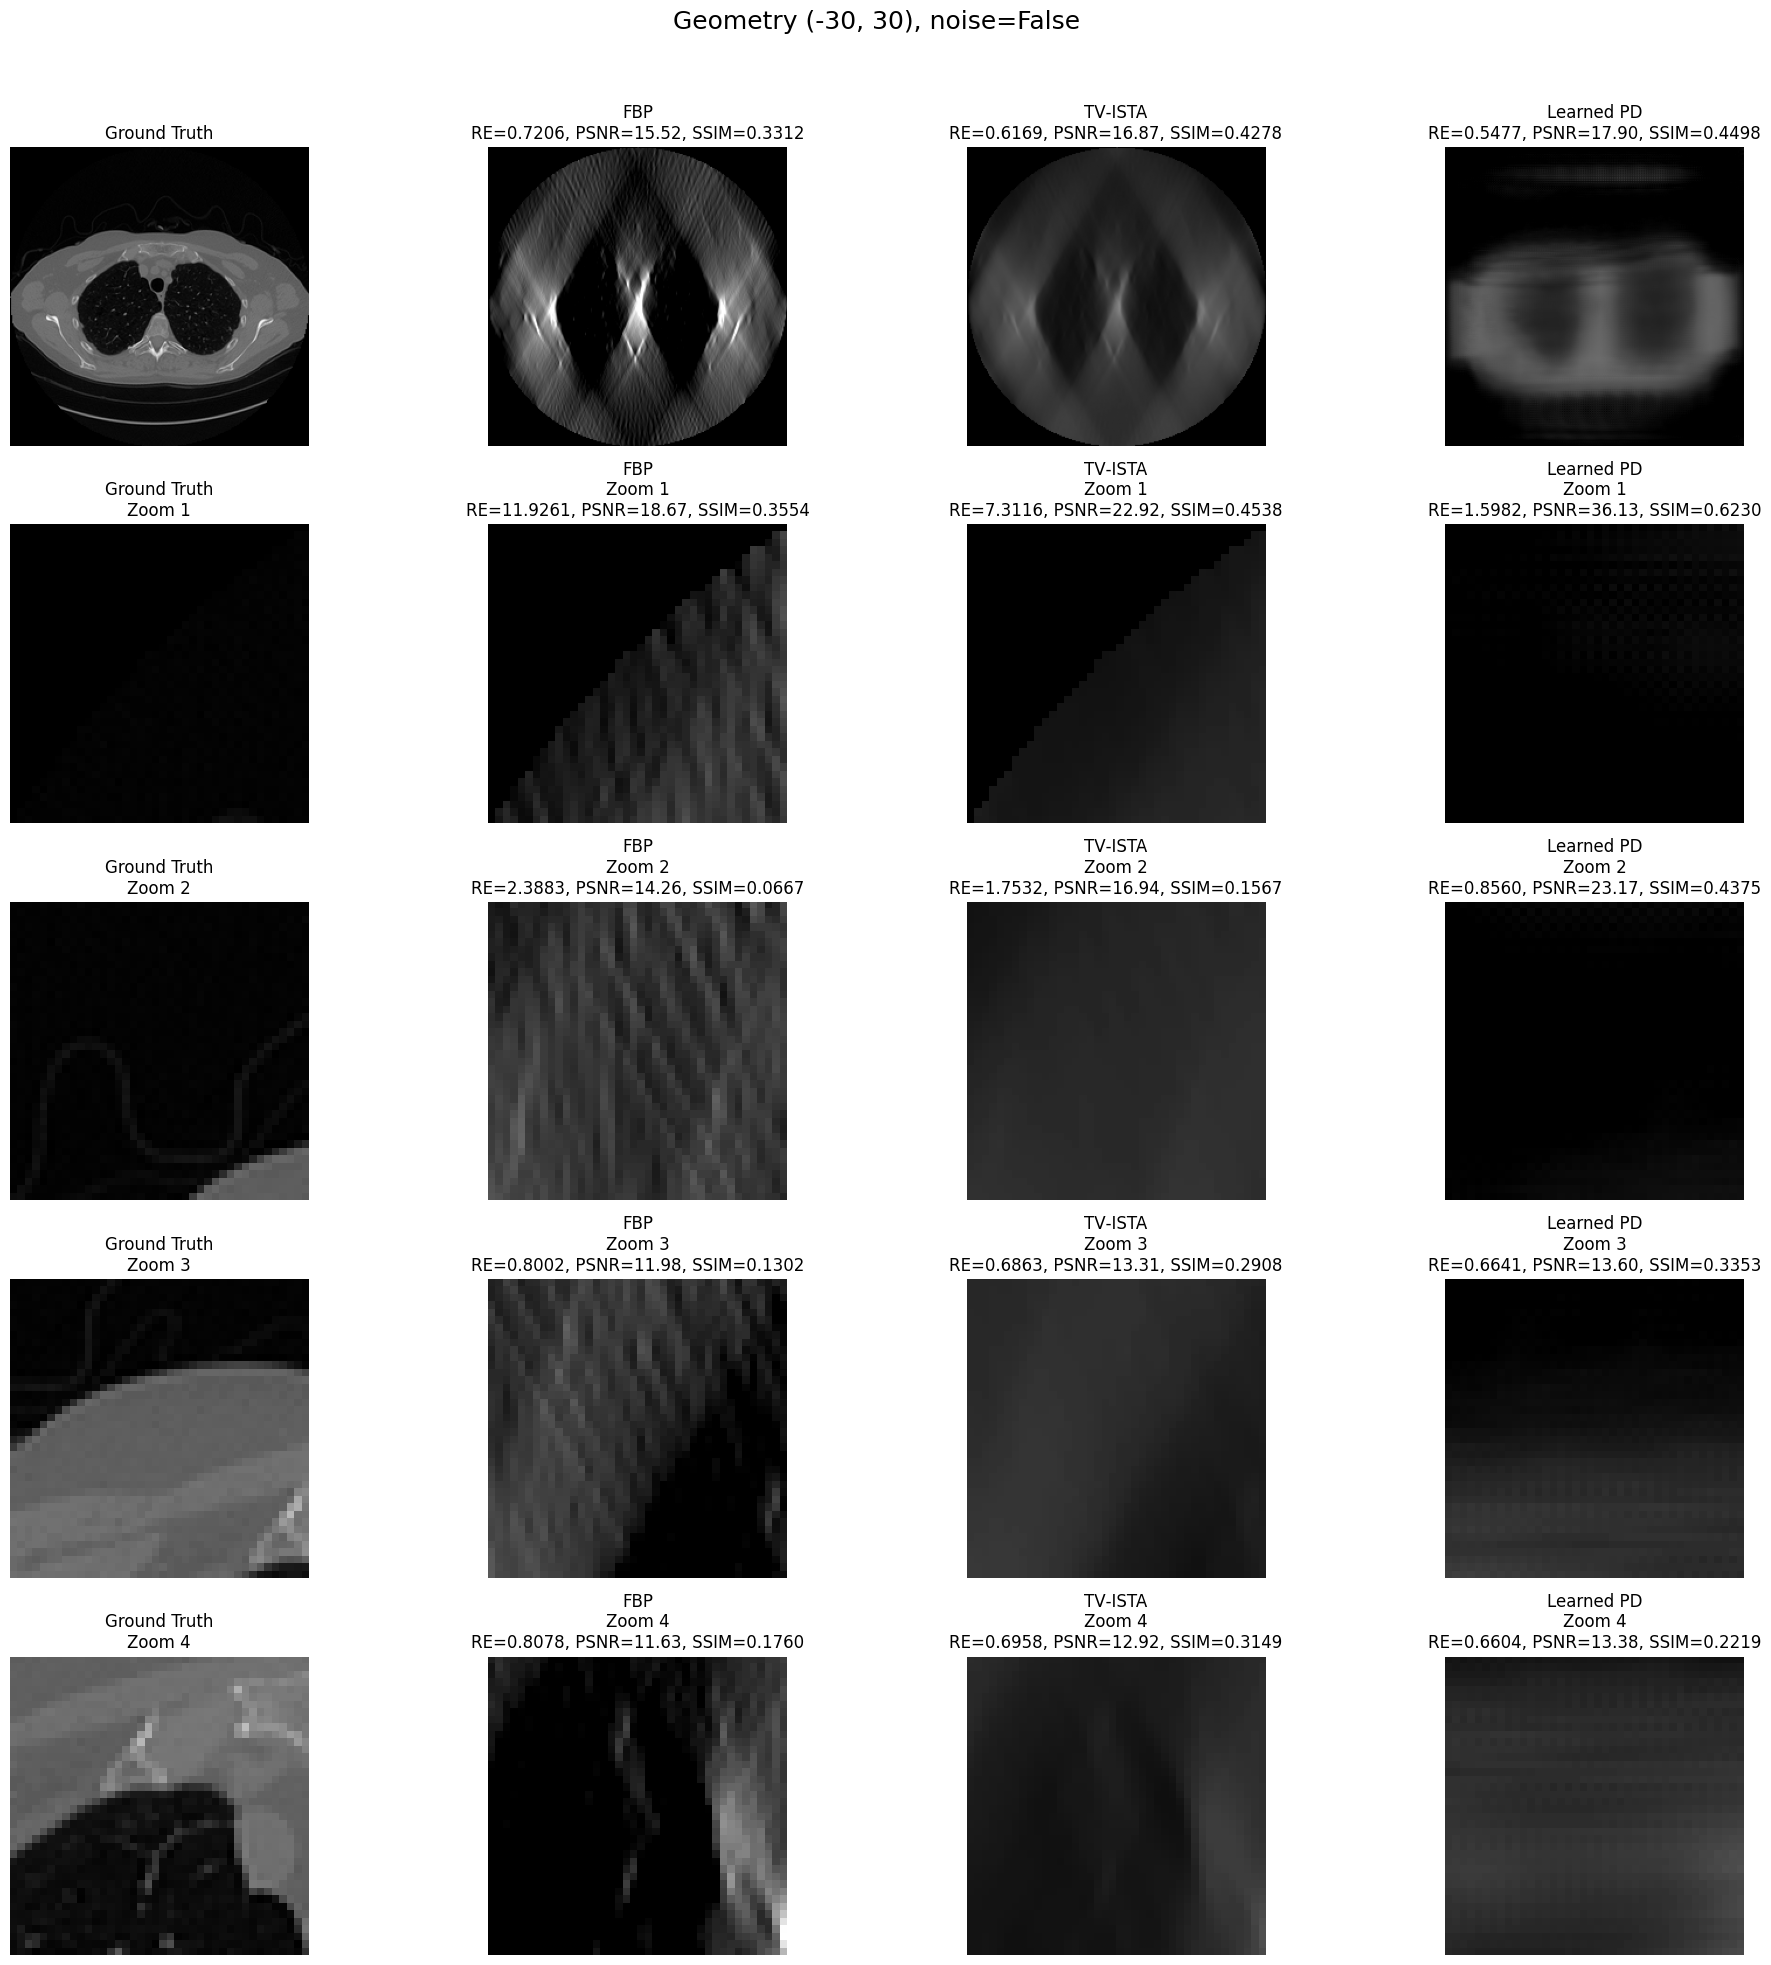

Iter 20/100 - Data Fidelity: 31570.9129
Iter 40/100 - Data Fidelity: 11701.8443
Iter 60/100 - Data Fidelity: 8960.2476
Iter 80/100 - Data Fidelity: 7594.7678
Iter 100/100 - Data Fidelity: 6690.3082


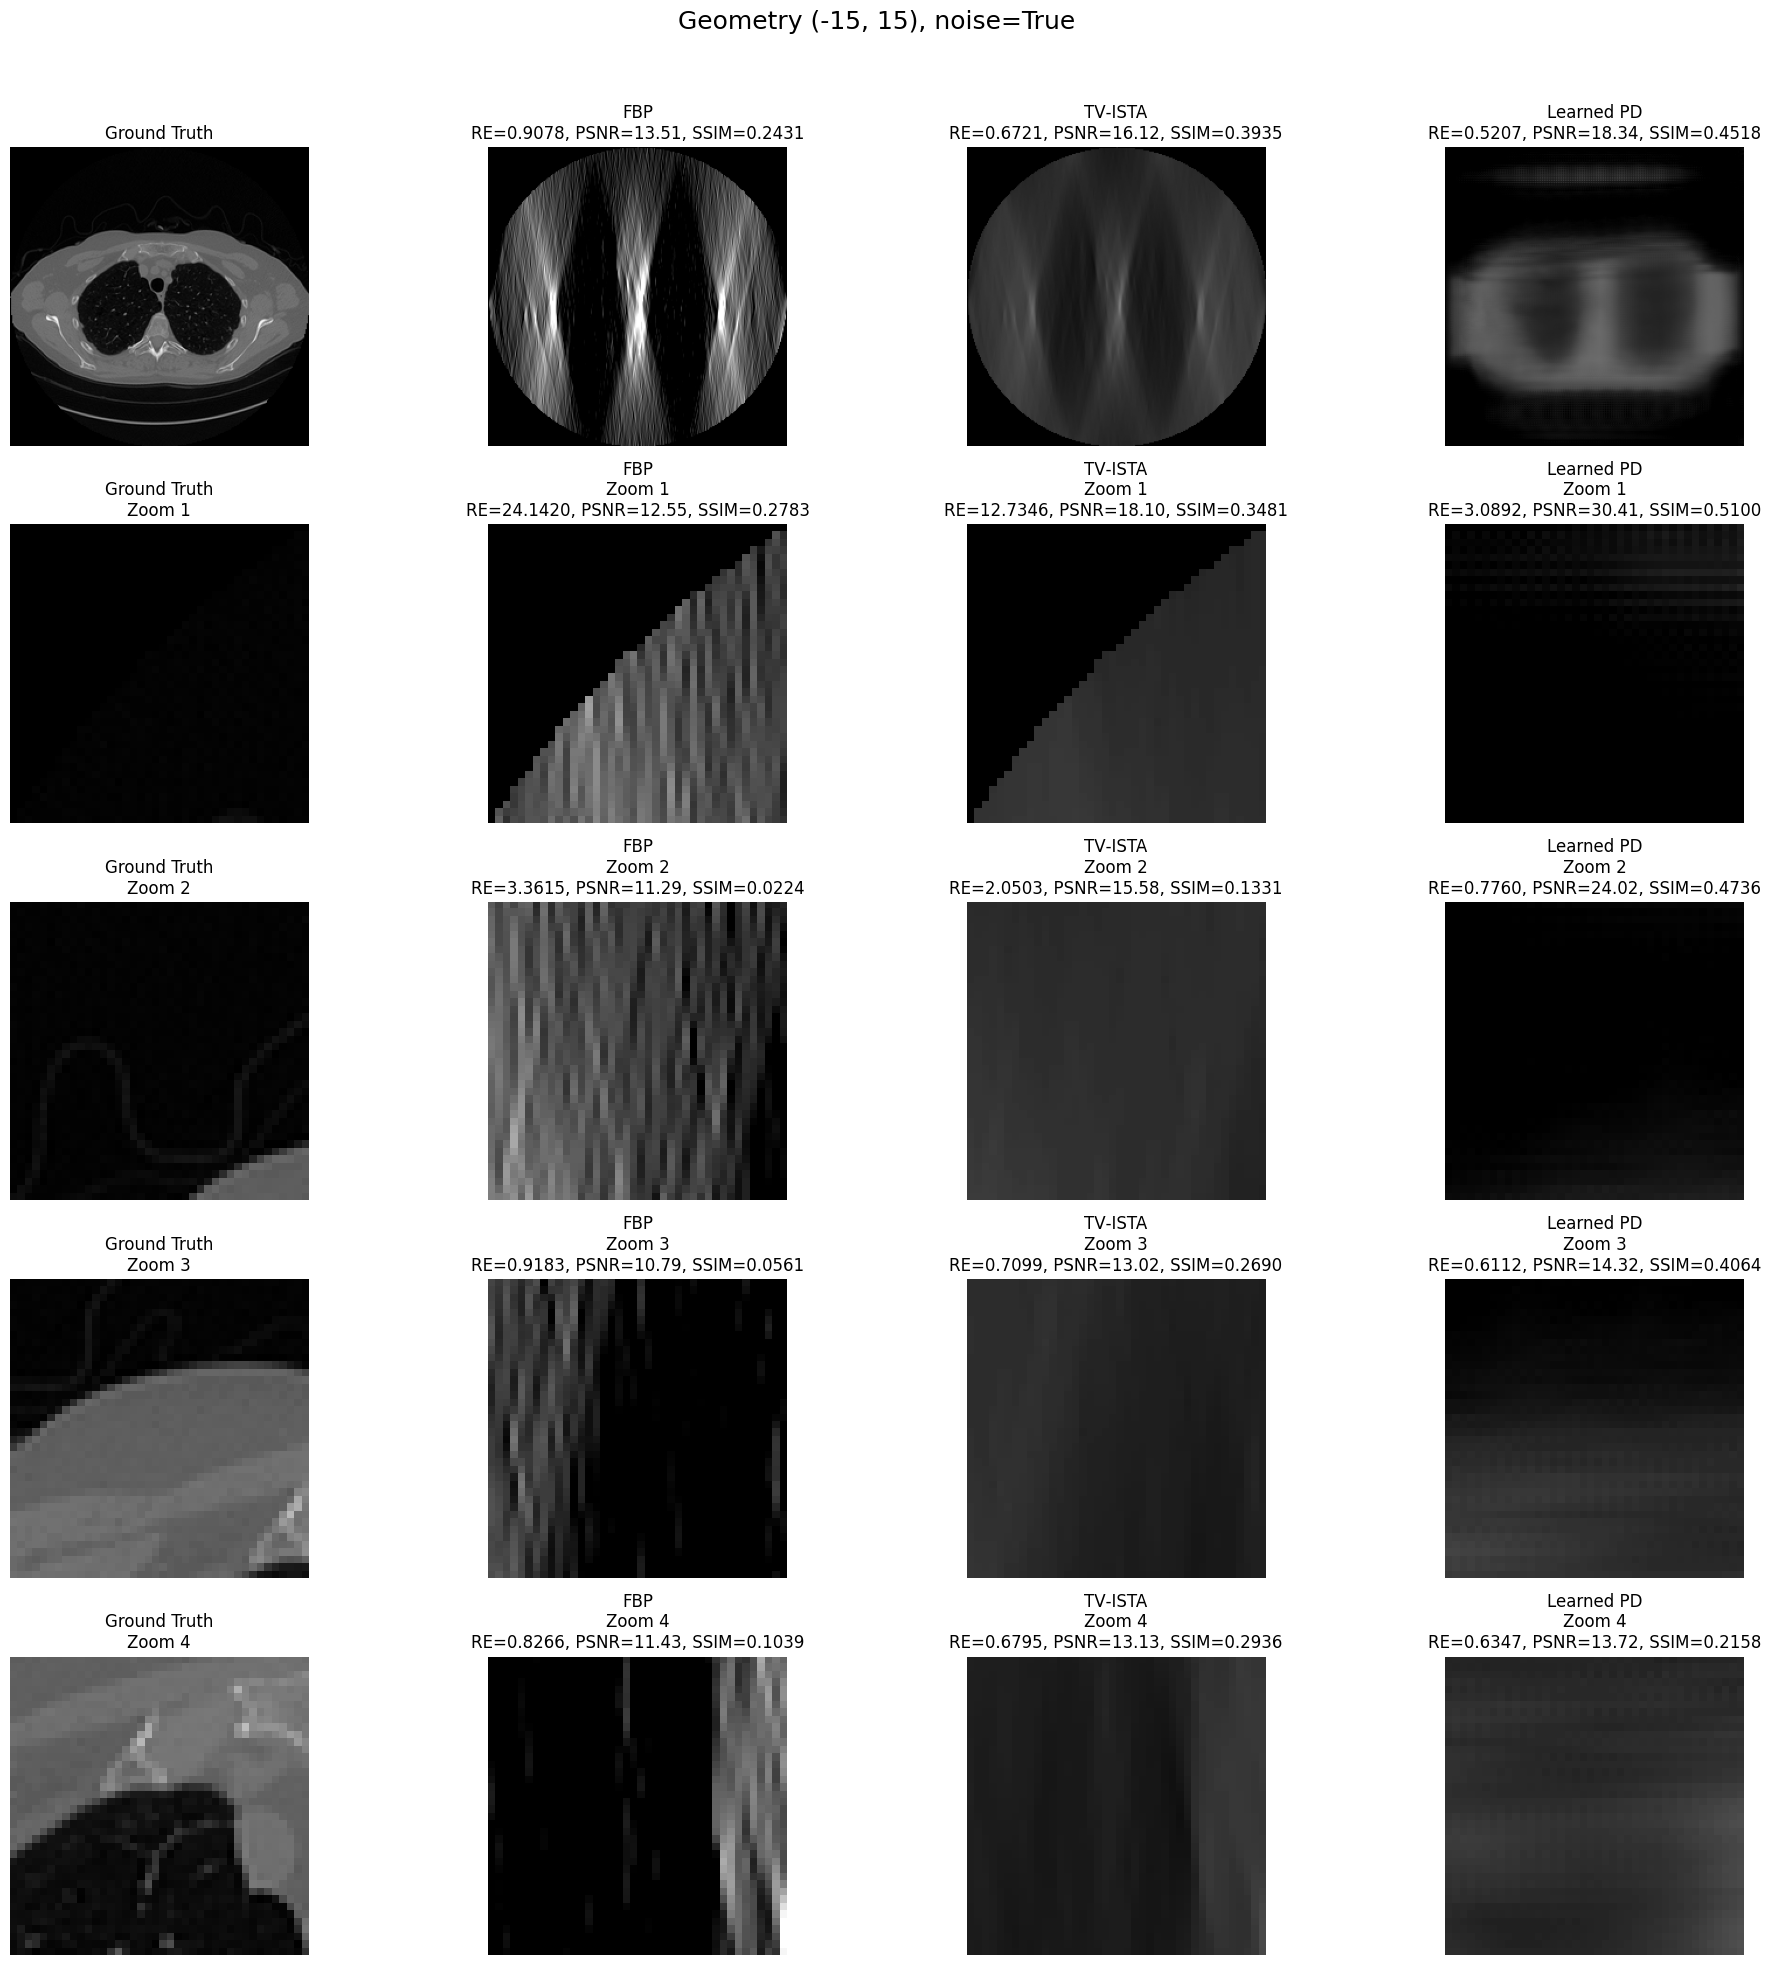

In [7]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt


net.eval()
for geom, noise_flag in zip(geometries, noise_flags):
    # Dataset/test-loader
    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size
    )
    test_loader = DataLoader(
        test_ds,
        batch_size = 1,
        shuffle    = False,
        num_workers= num_workers,
        pin_memory = pin_memory
    )

    # Prendi un sample
    sino_t, img_t = next(iter(test_loader))
    sino_t, img_t = sino_t.cuda(), img_t.cuda()

    # Sinogram e GT come numpy
    sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
    orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)
    theta   = np.linspace(geom[0], geom[1], num_angles, endpoint=True)

    # FBP
    fbp = iradon(sino_np, theta=theta, output_size=image_size,
                 filter_name='ramp', circle=True)
    fbp = np.clip(fbp, 0, 1)

    # TV‑ISTA
    ista = tv_reconstruct_ista(
        sinogram               = sino_np,
        theta                  = theta,
        lamda_tv               = lambda_tv_ista,
        n_iter                 = n_iterations_ista,
        image_shape            = orig_np.shape,
        initial_reconstruction = np.zeros(orig_np.shape)
    )
    ista = np.clip(ista, 0, 1)

    # Learned Primal‑Dual
    with torch.no_grad():
        out = net(sino_t, torch.zeros_like(img_t))
    lpd_np = np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32)
    lpd_np = np.clip(lpd_np, 0, 1)

    # Prepara liste di immagini e titoli (incl. GT)
    recs   = [orig_np, fbp, ista, lpd_np]
    titles = ["Ground Truth", "FBP", "TV‑ISTA", "Learned PD"]

    # Metriche solo per le immagini intere (saltiamo la GT)
    metrics_full = [("", "", "")]
    for rec in (fbp, ista, lpd_np):
        re_val   = relative_error(orig_np, rec)
        psnr_val = psnr(orig_np, rec, data_range=1.0)
        ssim_val = ssim(orig_np, rec, data_range=1.0, channel_axis=None)
        metrics_full.append((f"{re_val:.4f}", f"{psnr_val:.2f}", f"{ssim_val:.4f}"))

    # Plot 5x4 (1 full + 4 zoom)
    n_zoom = len(zoom_coords_list)
    fig, axs = plt.subplots(n_zoom + 1, 4, figsize=(20, 4 * (n_zoom + 1)))

    for idx, (img, title) in enumerate(zip(recs, titles)):
        # Prima riga: immagini intere
        ax_full = axs[0, idx]
        ax_full.imshow(img, cmap='gray', vmin=0, vmax=1)

        if idx == 0:
            ax_full.set_title(title)
        else:
            re_val, psn, ssi = metrics_full[idx]
            ax_full.set_title(f"{title}\nRE={re_val}, PSNR={psn}, SSIM={ssi}")
        ax_full.axis('off')

        # Righe successive: zoom
        for zoom_idx, zoom_coords in enumerate(zoom_coords_list):
            ax_zoom = axs[zoom_idx + 1, idx]
            ax_zoom.imshow(img[zoom_coords], cmap='gray', vmin=0, vmax=1)
            ax_zoom.axis('off')

            if idx == 0:
                # GT: solo titolo con zoom index
                ax_zoom.set_title(f"{title}\nZoom {zoom_idx+1}")
            else:
                # Calcola metriche nella zona zoomata
                gt_crop   = orig_np[zoom_coords]
                rec_crop  = img[zoom_coords]

                re_zoom   = relative_error(gt_crop, rec_crop)
                psnr_zoom = psnr(gt_crop, rec_crop, data_range=1.0)
                ssim_zoom = ssim(gt_crop, rec_crop, data_range=1.0, channel_axis=None)

                ax_zoom.set_title(
                    f"{title}\nZoom {zoom_idx+1}\nRE={re_zoom:.4f}, PSNR={psnr_zoom:.2f}, SSIM={ssim_zoom:.4f}"
                )

    fig.suptitle(f"Geometry {geom}, noise={noise_flag}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [14]:
import pandas as pd
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import torch
from torch.utils.data import DataLoader
from itertools import product

# Funzione per calcolare RE
def relative_error(gt, rec):
    return np.linalg.norm(gt - rec) / np.linalg.norm(gt)

# Parametri generali
MAX_SAMPLES_PER_CONDITION = 50
methods = ["FBP", "TV-ISTA", "Learned PD"]
metric_names = ["RE", "PSNR", "SSIM"]
zones = ["Full"] + [f"Zoom{i+1}" for i in range(len(zoom_coords_list))]


# Lista per raccogliere tutte le righe finali
all_table_rows = []

net.eval()

# Loop su tutte le combinazioni (4 condizioni)
for geom, noise_flag in product(geometries, noise_flags):
    geom_str = f"{abs(geom[0])}-{abs(geom[1])}"
    noise_str = "TRUE" if noise_flag else "FALSE"

    # Inizializza dizionario metriche per questa condizione
    metrics = {m: {z: {k: [] for k in metric_names} for z in zones} for m in methods}

    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size
    )
    test_loader = DataLoader(
        test_ds,
        batch_size = 1,
        shuffle    = False,
        num_workers= num_workers,
        pin_memory = pin_memory
    )

    theta = np.linspace(geom[0], geom[1], num_angles, endpoint=True)

    sample_count = 0
    for sino_t, img_t in test_loader:
        if sample_count >= MAX_SAMPLES_PER_CONDITION:
            break
        sample_count += 1

        sino_t, img_t = sino_t.cuda(), img_t.cuda()
        sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
        orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)

        # FBP
        fbp = iradon(sino_np, theta=theta, output_size=image_size,
                     filter_name='ramp', circle=True)
        fbp = np.clip(fbp, 0, 1)

        # TV‑ISTA
        ista = tv_reconstruct_ista(
            sinogram               = sino_np,
            theta                  = theta,
            lamda_tv               = lambda_tv_ista,
            n_iter                 = n_iterations_ista,
            image_shape            = orig_np.shape,
            initial_reconstruction = np.zeros(orig_np.shape)
        )
        ista = np.clip(ista, 0, 1)

        # Learned Primal‑Dual
        with torch.no_grad():
            out = net(sino_t, torch.zeros_like(img_t))
        lpd_np = np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32)
        lpd_np = np.clip(lpd_np, 0, 1)

        # Lista di ricostruzioni e metodi
        recs = [fbp, ista, lpd_np]
        for rec, method in zip(recs, methods):
            # Full metrics
            re_val   = relative_error(orig_np, rec)
            psnr_val = psnr(orig_np, rec, data_range=1.0)
            ssim_val = ssim(orig_np, rec, data_range=1.0, channel_axis=None)

            metrics[method]["Full"]["RE"].append(re_val)
            metrics[method]["Full"]["PSNR"].append(psnr_val)
            metrics[method]["Full"]["SSIM"].append(ssim_val)

            # Zoom metrics
            for i, zoom_coords in enumerate(zoom_coords_list):
                gt_crop  = orig_np[zoom_coords]
                rec_crop = rec[zoom_coords]

                re_z   = relative_error(gt_crop, rec_crop)
                psnr_z = psnr(gt_crop, rec_crop, data_range=1.0)
                ssim_z = ssim(gt_crop, rec_crop, data_range=1.0, channel_axis=None)

                zone_name = f"Zoom{i+1}"
                metrics[method][zone_name]["RE"].append(re_z)
                metrics[method][zone_name]["PSNR"].append(psnr_z)
                metrics[method][zone_name]["SSIM"].append(ssim_z)

    # Costruzione righe tabella per questa condizione
    for method in methods:
        row = {
            "Method": method,
            "Geometry": geom_str,
            "Noise": noise_str,
            "N Samples": sample_count
        }
        for zone in zones:
            for metric in metric_names:
                values = metrics[method][zone][metric]
                mean_val = np.mean(values)
                if metric == "PSNR":
                    row[f"{metric} ({zone})"] = f"{mean_val:.2f}"
                else:
                    row[f"{metric} ({zone})"] = f"{mean_val:.4f}"
        all_table_rows.append(row)

# Crea DataFrame unico
df_all = pd.DataFrame(all_table_rows)

# Stampa a schermo
print(df_all.to_string(index=False))

# Salva su Google Drive
output_filename = "/content/drive/MyDrive/metrics_summary_all_conditions.xlsx"
df_all.to_excel(output_filename, index=False)
print(f"\nTabella salvata in file: {output_filename}")


Iter 20/100 - Data Fidelity: 66491.5190
Iter 40/100 - Data Fidelity: 29277.6151
Iter 60/100 - Data Fidelity: 20698.5856
Iter 80/100 - Data Fidelity: 16088.8930
Iter 100/100 - Data Fidelity: 13130.2528
Iter 20/100 - Data Fidelity: 58450.2992
Iter 40/100 - Data Fidelity: 26021.8707
Iter 60/100 - Data Fidelity: 19243.4226
Iter 80/100 - Data Fidelity: 15962.9722
Iter 100/100 - Data Fidelity: 13940.2733
Iter 20/100 - Data Fidelity: 67732.3691
Iter 40/100 - Data Fidelity: 30406.7117
Iter 60/100 - Data Fidelity: 21741.2081
Iter 80/100 - Data Fidelity: 17062.9218
Iter 100/100 - Data Fidelity: 14047.6863
Iter 20/100 - Data Fidelity: 59265.1538
Iter 40/100 - Data Fidelity: 26781.6601
Iter 60/100 - Data Fidelity: 19960.4012
Iter 80/100 - Data Fidelity: 16640.6620
Iter 100/100 - Data Fidelity: 14583.4700
Iter 20/100 - Data Fidelity: 30170.0288
Iter 40/100 - Data Fidelity: 10401.8191
Iter 60/100 - Data Fidelity: 7739.8028
Iter 80/100 - Data Fidelity: 6438.6683
Iter 100/100 - Data Fidelity: 5586.965